# Multi-scale agent based model

To run this example, install the tumor2d package available here:
[Agent-based 2D Tumor growth model](https://github.com/ICB-DCM/tumor2d).
For details on the model, see
<a href="http://www.cell.com/cell-systems/abstract/S2405-4712(16)30412-4">Jagiella, Rickert, Theis, Hasenauer: Parallelization and high-performance computing enables automated statistical inference of multiscale models (2017)</a>.

Briefly, the model describes the growth of a tumor spheroid (see animations below).
We "measure" the radial density of proliferating cells, the radial extracellular matrix density and the spheroid radius over time.

Proliferating cells (orange)
<img src="t2danimation/dividing_bg_transparent.gif" style="width: 350px;">

Extracellular matrix intensity
<img src="t2danimation/ecm_bg_transparent.gif" style="width: 350px;">

In [1]:
from time import time
from tumor2d import simulate

start_time = time()
observation = simulate(division_rate=4.17e-2,
                       initial_spheroid_radius=1.2e1,
                       initial_quiescent_cell_fraction=7.5e-1,
                       division_depth=100,
                       ecm_production_rate=5e-3,
                       ecm_degradation_rate=8e-4,
                       ecm_division_threshold=1e-2)
print(f"Simulation took {time() - start_time:.2f}s")

Simulation took 27.78s


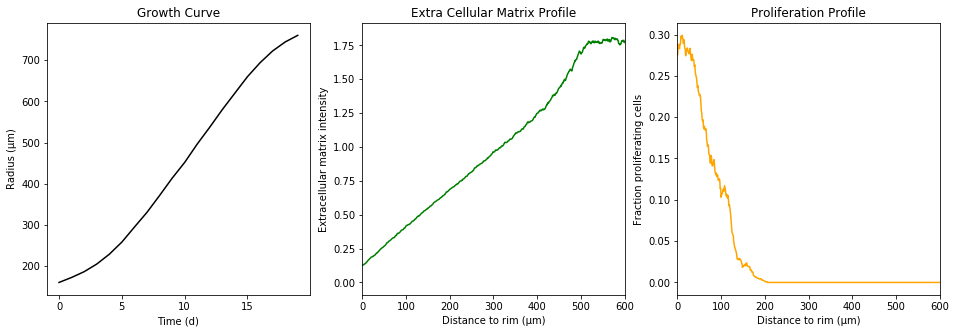

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from string import capwords

fig, axes = plt.subplots(ncols=3)
fig.set_size_inches((16, 5))

color = {"growth_curve": "k",
         "extra_cellular_matrix_profile": "green",
         "proliferation_profile": "orange"}

x_label = {"growth_curve": "Time (d)",
           "extra_cellular_matrix_profile": "Distance to rim (μm)",
           "proliferation_profile": "Distance to rim (μm)"}

y_label = {"growth_curve": "Radius (μm)",
           "extra_cellular_matrix_profile": "Extracellular matrix intensity",
           "proliferation_profile": "Fraction proliferating cells"}

for ax, (key, val) in zip(axes, observation.items()):
    ax.plot(val, color=color[key])
    ax.set_title(capwords(key.replace("_", " ")))
    ax.set_xlabel(x_label[key])
    ax.set_ylabel(y_label[key])
    if key.endswith("profile"):
        ax.set_xlim(0, 600)

In [3]:
from pyabc import Distribution, RV

limits = dict(log_division_rate=(-3, -1),
              log_division_depth=(1, 3),
              log_initial_spheroid_radius=(0, 1.2),
              log_initial_quiescent_cell_fraction=(-5, 0),
              log_ecm_production_rate=(-5, 0),
              log_ecm_degradation_rate=(-5, 0),
              log_ecm_division_threshold=(-5, 0))

prior = Distribution(**{key: RV("uniform", a, b - a) for key, (a,b) in limits.items()})

In [4]:
from tumor2d import log_model, distance, load_default
from pyabc import ABCSMC
from pyabc.sampler import ConcurrentFutureSampler
from concurrent.futures import ThreadPoolExecutor

data_mean = load_default()[1]

pool = ThreadPoolExecutor(max_workers=2)
sampler = ConcurrentFutureSampler(pool)

abc = ABCSMC(log_model, prior, distance,
             population_specification=10,
             sampler=sampler)

In [5]:
abc.new("sqlite:////tmp/test.db", data_mean)

INFO:Epsilon:initial epsilon is 16078681.637127472
INFO:History:Start <ABCSMC(id=5, start_time=2017-09-13 16:59:03.084964, end_time=None)>


5

In [6]:
history = abc.run(max_nr_populations=1, minimum_epsilon=0)

INFO:ABC:t:0 eps:16078681.6371


KeyboardInterrupt: 

In [ ]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

In [ ]:
from pyabc import History
from tumor2d import stored_data_db

h_loaded = History("sqlite:///" + stored_data_db)

df, w = h_loaded.get_distribution(m=0, t=5)
plot_kde_matrix(df, w, limits=limits);

In [ ]:
df, w = h_loaded.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

In [ ]:
populations = h_loaded.get_all_populations()
populations[populations.t >= 0].plot("t", "particles", marker="o");

In [ ]:
print(f"Notebook execution time: {time() - start_time:.1f}s")